In [36]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import svm
import functools
from scipy.stats import poisson

In [37]:
# Generate training data for sales probability regression
def generate_train_data(B=1000, T=100):

    def rank(a, p):
        return np.argsort(np.hstack((a, p)))[:,0]
    
    our_price = 16 + np.random.uniform(0, 4, (B, 1))
    competitor_prices = 16 + np.random.uniform(0, 4, (B, 5))
    our_rank = np.reshape(rank(our_price, competitor_prices), (B, 1))
    X = np.hstack((our_price, competitor_prices, our_rank))
    
    # Y = (our_rank == 0).astype(int).ravel()
    Y = np.maximum(0, (3 - our_rank)).astype(int).ravel()
    # Y = np.round(np.random.uniform(0, 1, our_rank.shape) * (1 - our_rank / 11)).ravel()
    
    return (X, Y)

X, Y = generate_train_data()

In [38]:
# Train sales probability model
def make_model(X, Y):
    regr = linear_model.LinearRegression()
    regr.fit(X, Y)
    def predict(x):
        return np.maximum(0, regr.predict(x))
        # return regr.predict_proba(x)[:, 1]
    return predict

sales_model = make_model(X, Y)

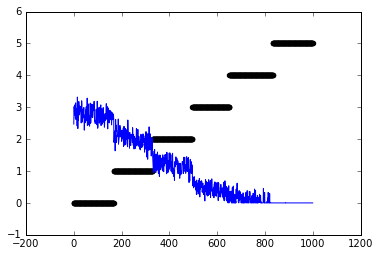

In [39]:
# Plot sales probability model
X_train, _ = generate_train_data(1000)
X_sort = np.sort(X_train.view('f8,f8,f8,f8,f8,f8,f8'), order=['f6'], axis=0).view(float)
plt.scatter(np.arange(0, X_sort.shape[0]), X_sort[:, 6], color='black')
plt.plot(np.arange(0, X_sort.shape[0]), sales_model(X_sort), color='blue', linewidth=1)

plt.show()

In [ ]:
class OptimizeOptions():
    def __init__(self, sales_model, competitor_prices,
               T, N, L, Z, delta, price_range):
        self.sales_model = sales_model
        self.competitor_prices = competitor_prices
        self.T = T
        self.N = N
        self.L = L
        self.Z = Z
        self.delta = delta
        self.price_range = price_range

def optimize_run(t, N, options):
    def rank(a, p):
        _rank = p.shape[0]
        for i in range(p.shape[0]):
            if a < p[i]:
                _rank = _rank - 1
        return _rank

    @functools.lru_cache(maxsize=None)
    def sales_prob(price, options):
        x = np.hstack((price, options.competitor_prices, rank(price, options.competitor_prices))).reshape(1, -1)
        return sales_model(x)[0]


    @functools.lru_cache(maxsize=None)
    def _V(price, t, n, options):
        p = sales_prob(price, options)
        _sum = 0
        for i in range(int(poisson.ppf(0.9999, p)) + 1):
            if i > n:
                return 0
            pi = poisson.pmf(i, p)
            today_profit = min(n, i) * price
            holding_costs = n * options.L
            V_future, _ = V(t + 1, max(0, n - i), options)
            exp_future_profits = options.delta * V_future
            _sum += pi * (today_profit - holding_costs + exp_future_profits)
        return _sum
    

    @functools.lru_cache(maxsize=None)
    def V(t, n, options):
        if t >= options.T:
            return (n * options.Z, 0)
        if n <= 0:
            return (0, 0)

        V_opt = -100000
        price_opt = -100000
        for i, price in enumerate(options.price_range):
            v = _V(price, t, n, options)
            if v > V_opt:
                V_opt = v
                price_opt = price

        return (price_opt, V_opt)

    return V(t, N, options)
    

# Run Bellmann equation to calculate best price
def optimize_price(t, sales_model, competitor_prices,
               T=5, N=15, 
               price_range=np.arange(0.1, 20, 0.1), 
               L=0.01, delta=0.99, Z=0.5):

    return optimize_run(t, N, OptimizeOptions(sales_model, competitor_prices,
               T, N, L, Z, delta, price_range))

optimize_price(0, sales_model, np.random.uniform(0, 20, 5))

(12.5, 26.115739350900686)

In [ ]:
def simulation(sales_model, competitor_prices, T=20, N=15):
    n = N
    
    def rank(a, p):
        order = np.argsort(np.hstack((a, p)))
        ranks = np.argsort(order)
        return ranks[0]
    
    def sales_prob(price):
        x = np.hstack((price, competitor_prices, rank(price, competitor_prices))).reshape(1, -1)
        return sales_model(x)[0]
   
    price_history = []
    accumulated_sales = []
    
    profit = 0

    for t in range(0, T):
        price, V = optimize_price(t, sales_model, competitor_prices, N=n, T=T)
        if t == 0:
            print(V)
        price_history.append(price)
        pi = sales_prob(price)
        sales = min(n, np.random.poisson(pi))
        n = n - sales
        profit += price * sales
        accumulated_sales.append(N - n)
        print(t, n, price, pi, competitor_prices, rank(price, competitor_prices))
        # competitor_prices = competitor_prices * np.random.uniform(0.8, 1.2, 5)
        
    plt.plot(price_history)    
    plt.ylabel('Price Path')
    plt.show()
    
    plt.plot(accumulated_sales)    
    plt.ylabel('Accumulated Sales')
    plt.show()
    
    print(profit)
    return profit

simulation(sales_model, np.random.uniform(0, 20, 5))

In [ ]:
competitor_prices = np.random.uniform(0, 20, 5)
profits = list(map(lambda i: simulation(sales_model, competitor_prices), range(0, 20)))
    
n, bins, patches = plt.hist(profits, 10, normed=1, facecolor='green', alpha=0.75)

plt.xlabel('Profit')
plt.ylabel('Probability')
plt.show()